In [10]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime
from meteostat import Stations, Daily, Hourly
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geos
import pandas as pd
import numpy as np
import os

In [11]:
scope = ["https://spreadsheets.google.com/feeds",
         'https://www.googleapis.com/auth/spreadsheets',
         "https://www.googleapis.com/auth/drive.file",
         "https://www.googleapis.com/auth/drive"]

creds = ServiceAccountCredentials.from_json_keyfile_name("WetterstationIT.json", scope)
client = gspread.authorize(creds)

In [22]:
temp = "Temperatur in (°C)"
rhum = "Relative Luftfeuchtigkeit in (%)"
pres = "Luftdruck in (hPa)"

locations = ("Euskirchen", "Schmidt, Nideggen", "Muetzenich")
parameters = (temp, rhum, pres)

#Koordinaten vom Ort
def get_coordinates(location):
    geolocator = Nominatim(user_agent="Wetterstation")
    location = geolocator.geocode(location)
    coordinates = (location.latitude, location.longitude)
    return coordinates  

#nächste Wetterstation von Koordinaten
def get_closest_weather_station(lat, lon, start, end):
    stations = Stations()
    stations = stations.nearby(lat, lon)
    stations = stations.inventory('hourly', (start, end))
    station = stations.fetch(1)
    return station

#Prognostizierte Daten auslesen und zeitlich eingrenzen
def get_prognosed_data(station, start, end):
    data = Hourly(station, start=start, end=end)
    data = data.normalize()
    data = data.interpolate()
    data = data.fetch()
    data = data[["temp", "rhum", "pres"]]
    data = data.rename(columns={"temp": temp, "rhum": rhum, "pres": pres})
    data = data.loc[data.index >= start]
    data = data.loc[data.index <= end]
    return data

#gemessene Daten auslesen
def get_measurement_data(location):
    sheet = client.open(location).sheet1  # Open the spreadhseet
    data = sheet.get_all_records()  # Get a list of all records
    data = pd.DataFrame(data)
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index(keys = data["Date"])
    data = data[["Temperatur", "Humidity", "Pressure"]]
    data = data.rename(columns={"Temperatur": temp, "Humidity": rhum, "Pressure": pres})
    # clear data from units
    data[temp] = data[temp].str.strip("C")
    data[rhum] = data[rhum].str.strip("%")
    data[pres] = data[pres].str.strip("hPa")
    data = data.astype("float")
    return data

In [55]:
mean_std = {}
for location in locations:

    #get measured data

    measured_data = get_measurement_data(location)
    
    #get prognosed data
    start = measured_data.index[0]
    end = measured_data.index[-1]
    
    #Nächste Wetterstation von Muetzenich gibt keine Daten aus; die nächste die Daten ausgibt ist Elsenborn
    if location == "Muetzenich":
        location = "Elsenborn"
    else:
        pass
    
    lat, lon = get_coordinates(location)
    station = get_closest_weather_station(lat, lon, start, end)
    prognosed_data = get_prognosed_data(station, start, end)
    
    if location == "Elsenborn":
        location = "Muetzenich"
    else:
        pass
    
    #Iteriere über die Parameter und erstelle Plot für jeden Parameter (für jeden Ort)
    for parameter in parameters:
        
        plt.ioff()
        plt.clf()
        plt.title(location)  
        measured_data[parameter].plot(label = "gemessen")
        prognosed_data[parameter].plot(label = "prognostiziert")
        mean = np.mean(measured_data[parameter]-prognosed_data[parameter])
        std = np.std(measured_data[parameter]-prognosed_data[parameter])
        
        mean_std[(str(location) + ": "+ str(parameter))] = {"Mittlere Abweichung: ": mean, "Standardabweichung: ": std}
        
        plt.xlabel("Datum")
        plt.ylabel(parameter)
        plt.legend()
        
        file_name = parameter + " " +  location
        
        dir_name = "figures"
        file_path = os.path.join(dir_name, file_name)
        
        # Versuche Datei im Ordner zu speichern. Falls Ordner nicht vorhanden ist: Ordner erstellen; Datei speichern
        try:
            plt.savefig(file_path)
            
        except:
            os.mkdir(dir_name)
            plt.savefig(file_path)
        plt.close()


Bitte geben sie einen Ort ein (('Euskirchen', 'Schmidt, Nideggen', 'Muetzenich')): Schmidt, Nideggen
Welchen Parameter möchten Sie abfragen? (('Temperatur in (°C)', 'Relative Luftfeuchtigkeit in (%)', 'Luftdruck in (hPa)'))
Bitte geben Sie einen Parameter ein: Temperatur in (°C)


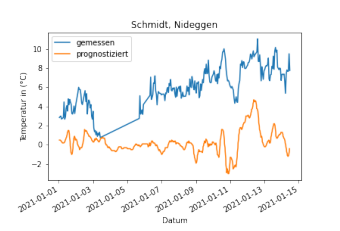

Alle Plots finden Sie unter folgendem Pfad:
/Users/matthiassimons/OneDrive - Fachhochschule Aachen/Studium/Master/Programmierung und Informationsverarbeitung/Wetterstation/figures


In [21]:
files = os.listdir(dir_name)
#User Abfrage: Ort
location = input ("Bitte geben sie einen Ort ein ({}): ".format(locations))

while location not in locations:
    print("Ort nicht verfügbar - Bitte erneut Eingeben.")
    location = input("Bitte geben Sie einen Ort ein ({}): ".format(locations))

#User Abfrage: Parameter
parameter = input ("Welchen Parameter möchten Sie abfragen? ({})\nBitte geben Sie einen Parameter ein: ".format(parameters))

while parameter not in parameters:
    print("Parameter nicht verfügbar - Bitte erneut Eingeben.")
    parameter = input("Bitte geben Sie einen Parameter ein ({}): ".format(parameters))

#gewünschten Plot öffnen und anzeigen
for file in files:
    if parameter in file and location in file:      
        img = mpimg.imread(os.path.join(dir_name, file))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

#absoluter Pfad wo die Plots gespeichert sind
print("Alle Plots finden Sie unter folgendem Pfad:\n" + os.path.abspath(dir_name))       

In [72]:
for value in mean_std:
    print(str(value) + ": \n" + 
          'Mittlere Abweichung: '+ str(round(mean_std[value]['Mittlere Abweichung: '], 2)) + "\n"
    + 'Standardabweichung: '+ str(round(mean_std[value]['Standardabweichung: '],2 )) + "\n")

Euskirchen: Temperatur in (°C): 
Mittlere Abweichung: 1.42
Standardabweichung: 0.74

Euskirchen: Relative Luftfeuchtigkeit in (%): 
Mittlere Abweichung: -16.38
Standardabweichung: 2.64

Euskirchen: Luftdruck in (hPa): 
Mittlere Abweichung: 16.17
Standardabweichung: 0.82

Schmidt, Nideggen: Temperatur in (°C): 
Mittlere Abweichung: 1.91
Standardabweichung: 0.73

Schmidt, Nideggen: Relative Luftfeuchtigkeit in (%): 
Mittlere Abweichung: -23.79
Standardabweichung: 3.48

Schmidt, Nideggen: Luftdruck in (hPa): 
Mittlere Abweichung: -19.71
Standardabweichung: 0.31

Muetzenich: Temperatur in (°C): 
Mittlere Abweichung: -1.36
Standardabweichung: 0.56

Muetzenich: Relative Luftfeuchtigkeit in (%): 
Mittlere Abweichung: -10.14
Standardabweichung: 1.73

Muetzenich: Luftdruck in (hPa): 
Mittlere Abweichung: -30.42
Standardabweichung: 0.75

